# Coursework 2: Image Classification

In this coursework, we are going to develop a neural network model for for image classification.

What to do?

* The coursework includes both coding questions and written questions. Please read both the text and code comment in this notebook to get an idea what you are supposed to implement.

* First, run `jupyter-lab` or `jupyter-notebook` in the terminal to start the Jupyter notebook.

* Then, complete and run the code to get the results.

* Finally, please export (File | Export Notebook As...) or print (using the print function of your browser) the notebook as a pdf file, which contains your code, results and answers, and upload the pdf file onto Cate.

Dependencies:

* If you work on a college computer in the Computer Lab, where Ubuntu 18.04 is installed by default, you can use the following virtual environment for your work, where required Python packages are already installed.

`source /vol/bitbucket/wbai/virt/computer_vision_2020/bin/activate`

When you no longer need the virtual environment, you can exit it by running `deactivate`.

* If you work on your own laptop using either Anaconda or plain Python, you can install new packages (such as numpy, imageio etc) running `conda install [package_name]` or `pip3 install [package_name]` in the terminal.

In [4]:
# Import libraries (provided)
import numpy as np 
import matplotlib.pyplot as plt
import time
import random
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# 1. Load and visualise data. (25 marks)

Throughout this coursework. you will be working with the Fashion-MNIST dataset. If you are interested, you may find information about the dataset in this paper.

[1] Han Xiao, Kashif Rasul, Roland Vollgraf. Fashion-MNIST: A novel image dataset for benchmarking machine learning algorithms. [arXiv:1708.07747](https://arxiv.org/abs/1708.07747)

The dataset is prepared in a similar way to MNIST. It is split into a set of 60,000 training images and a set of 10,000 test images. The images are of size 28x28 pixels.

There are in total 10 label classes, which are:
* 0: T-shirt/top
* 1: Trousers
* 2: Pullover
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle boot

In [5]:
# Load data (provided)

transform = transform = transforms.Compose([
transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

train_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=True,transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4,
                                          shuffle=True, num_workers=2)
train_image = np.array(train_set.data)
train_label = np.array(train_set.targets) #number from 0 to 9
class_name = train_set.classes  # names in string

test_set = torchvision.datasets.FashionMNIST(root='.', download=True, train=False,transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,
                                         shuffle=True, num_workers=2)
test_image = np.array(test_set.data)
test_label = np.array(test_set.targets) #number from 0 to 9


### 1.1 Display the dimension of the training and test sets. (5 marks)

In [4]:


[train_num, h1, w1] = train_image.shape

[test_num, h2, w2] = test_image.shape

print("training set has {} images, each with dimension {} x {}".format(train_num, h1, w1))
print("test set has {} images, each with dimension {} x {}".format(test_num, h2, w2))




training set has 60000 images, each with dimension 28 x 28
test set has 10000 images, each with dimension 28 x 28


### 1.2 Visualise sample images for each of the 10 classes. (10 marks)

Please plot 10 rows x 10 columns of images. Each row shows 10 samples for one class. For example, row 1 shows 10 `T-shirt/top` images, row 2 shows 10 `Trousers` images.

(28, 28)
uint8


[]

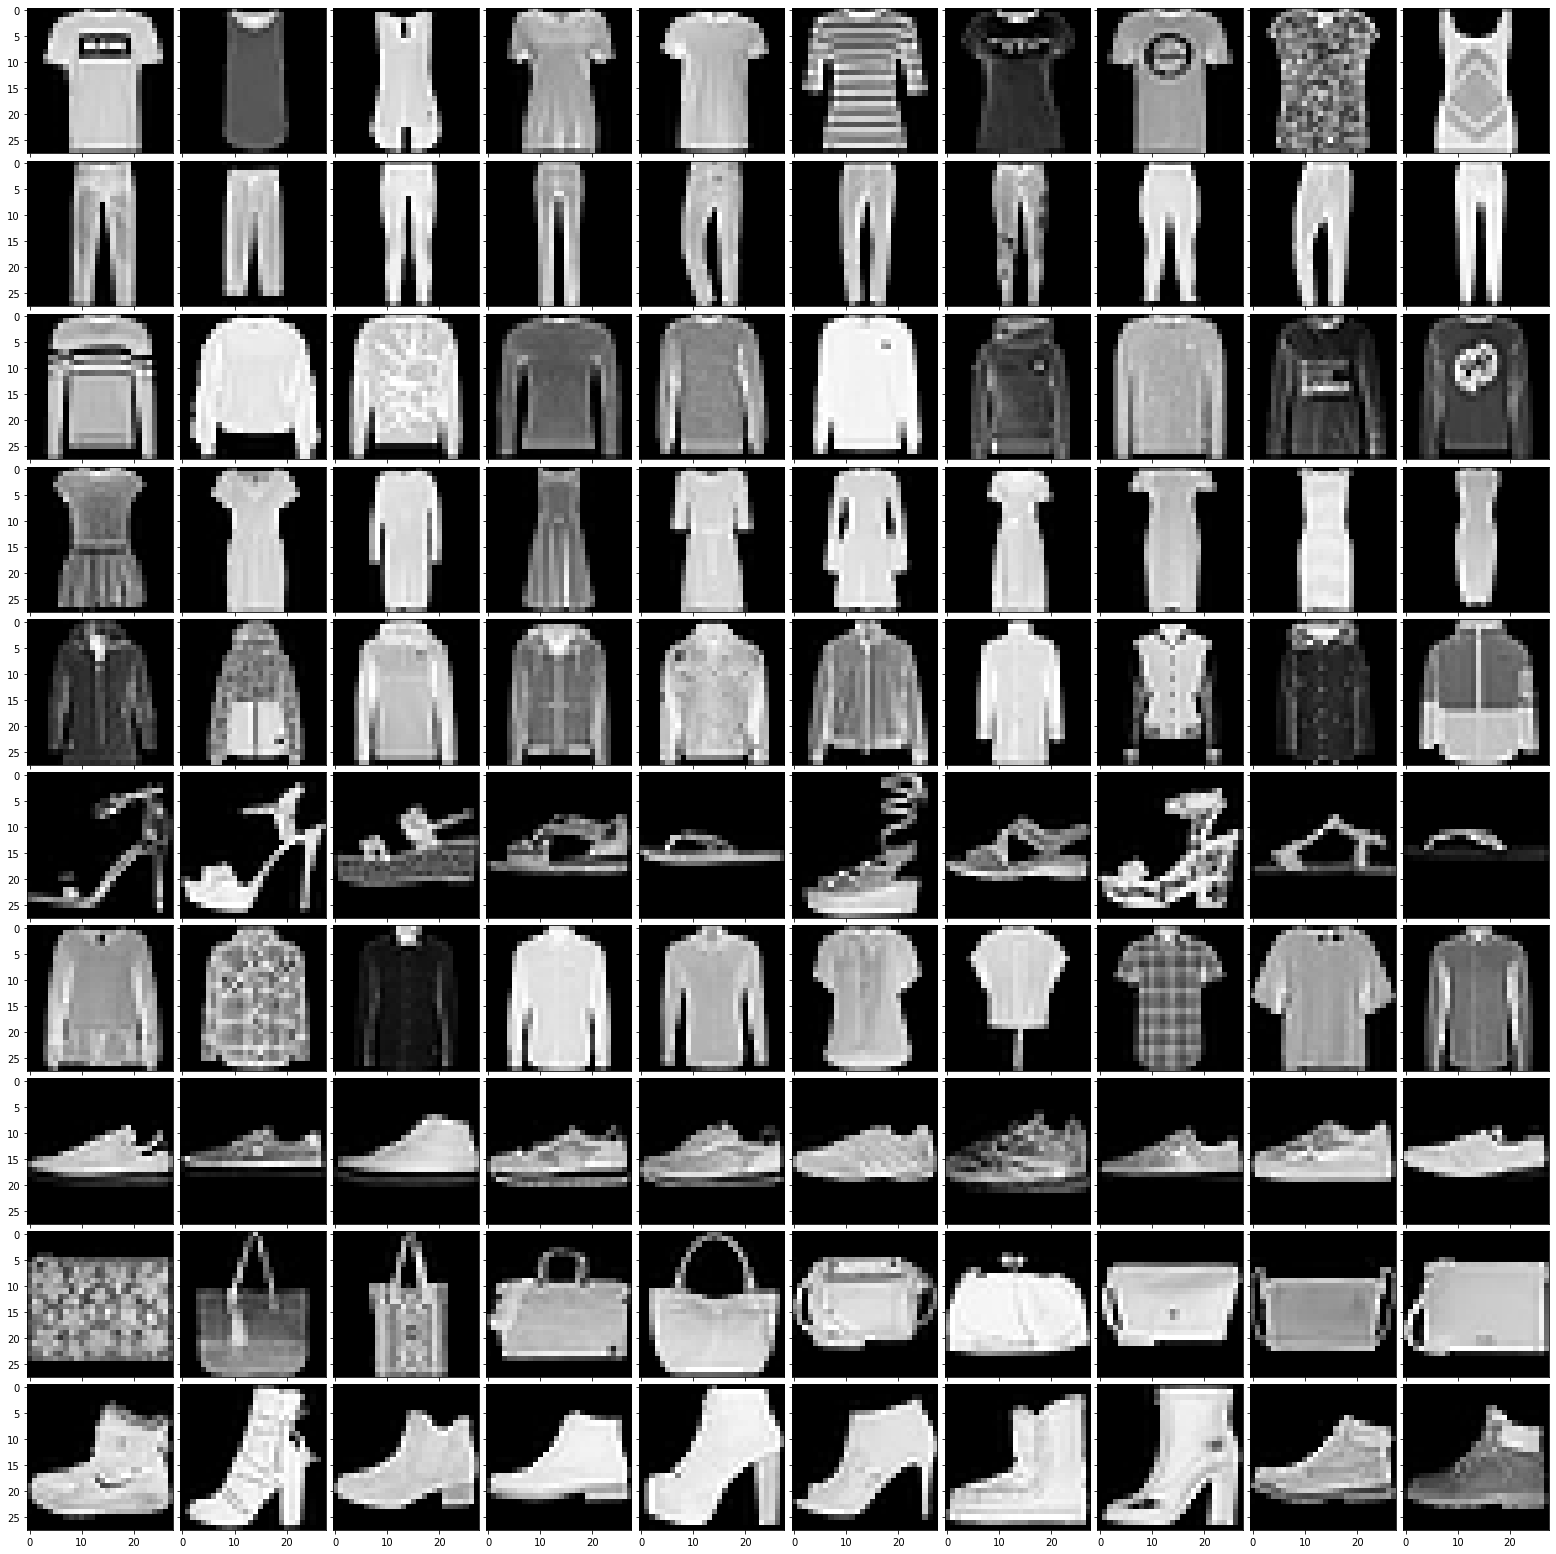

In [49]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(28., 28.))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(10, 10),  
                 axes_pad=0.1)
ims = []
for i in range(10):
    x = 0
    for j in range(10):
            find = False   
            while(not find):
                if(train_label[x] == i):
                    ims.append(train_image[x])
                    find = True
                x = x + 1

print(train_image[0].shape)
print(train_image[0].dtype)

                
for ax, im in zip(grid, ims):
    ax.imshow(im,cmap='gray', interpolation='none')
    
plt.plot()


### 1.3 Display the number of training samples for each class. (5 marks)

In [15]:
im_num = [0] * 10

for i in range(10): #10 classes
    for j in range(train_num):
            if(train_label[j] == i):
                im_num[i] += 1
    print("{}, {} class has {} images".format(i, class_name[i], im_num[i]))

0, T-shirt/top class has 6000 images
1, Trouser class has 6000 images
2, Pullover class has 6000 images
3, Dress class has 6000 images
4, Coat class has 6000 images
5, Sandal class has 6000 images
6, Shirt class has 6000 images
7, Sneaker class has 6000 images
8, Bag class has 6000 images
9, Ankle boot class has 6000 images


### 1.4 Discussion. (5 marks)
Is the dataset balanced? What would happen for the image classification task if the dataset is not balanced? 

The dataset is balanced because every class has the same number of training images(6000).

If the dataset is not balanced, not all classes are equally represented and not all evaluation metrics are reliable.
For example, accuracy can be affected a lot by majority classes. So we should look at all the metrics and the confusion matrix at the same time to detect the imbalance of dataset.

## 2. Image classification. (60 marks)

### 2.1 Build a convolutional neural network using the `PyTorch` library to perform classification on the Fashion-MNIST dataset. (15 marks)

You can use a network architecture similar to LeNet (shown below), which consists a number of convolutional layers and a few fully connected layers at the end.

![](lenet.png)

In [6]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5,padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 2.2 Define the loss function, optimiser and hyper-parameters such as the learning rate, number of iterations, batch size etc. (5 marks)

In [82]:

#instance of the Conv Net
cnn = CNN()
#loss function and optimizer
epoch_num = 10
rate = 1e-3
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(cnn.parameters(), lr=rate,momentum=0.9, weight_decay= 1e-3)



### 2.3 Start model training. (20 marks)

At each iteration, get a random batch of images and labels from train_image and train_label, convert them into torch tensors, feed into the network model and perform gradient descent. Please also evaluate how long it takes for training.

In [83]:
torch.manual_seed(13)

# batch size = 4
# loop over the dataset 13 times

print("learning rate is {}".format(rate))

for epoch in range(1):  
    if epoch % 5 == 4:
        rate *= 0.1 
        optimizer.lr = rate
        print("learning rate changed to {}".format(rate))

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5000 == 4999:    # print every 5000 mini-batches, 5000*4 samples 
            print('[epoch: %d, sample trained: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5000))
            running_loss = 0.0
            print(inputs.shape)

print('Finished Training')

learning rate is 0.001
[epoch: 1, sample trained:  5000] loss: 0.874
torch.Size([4, 1, 28, 28])


KeyboardInterrupt: 

In [84]:
# save the trained model
PATH = './cifar_net.pth'
torch.save(cnn.state_dict(), PATH)

### 2.4 Deploy the trained model onto the test set. (10 marks)
Please also evaluate how long it takes for testing.

In [86]:
from pylab import *
PATH = './cifar_net.pth'
net = CNN()
net.load_state_dict(torch.load(PATH))

correct = 0.0
total = 0.0
pred = []
#test_label is the true label

t0 = time.perf_counter()

for data in test_loader: 
    images, labels = data #a batch
    outputs = net(images)
#     print(images.dtype)
#     print(images.shape)
    predicted = torch.max(outputs.data, 1)[1]
    pred.extend(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
t1 = time.perf_counter()
print("time used in testing: {}".format(t1-t0))

time used in testing: 5.364679737947881


### 2.5 Evaluate the classification accuracy on the test set. (5 marks)

In [17]:
print('Accuracy : %d %%' % (100.0 * correct / total))

Accuracy : 90 %


### 2.6 Print out and visualise the confusion matrix. (5 marks)
You can use relevant functions in [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

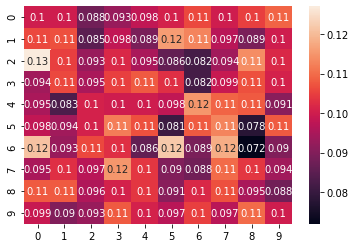

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cmx = confusion_matrix(test_label, pred,normalize='true')

sns.heatmap(cmx, annot=True)

## 3. Deploy in real world. (15 marks)

Take 3 photos that belongs to the 10 classes (e.g. clothes, shoes) in your real life. Use either Python or other software (Photoshop, Gimp etc) to convert the photos into grayscale, negate the intensities so that background becomes black or dark, crop the region of interest and reshape into the size of 28x28.

### 3.1 Load and visualise your own images (5 marks)

(28, 28)
float32
(28, 28)
float32
(28, 28)
float32


[]

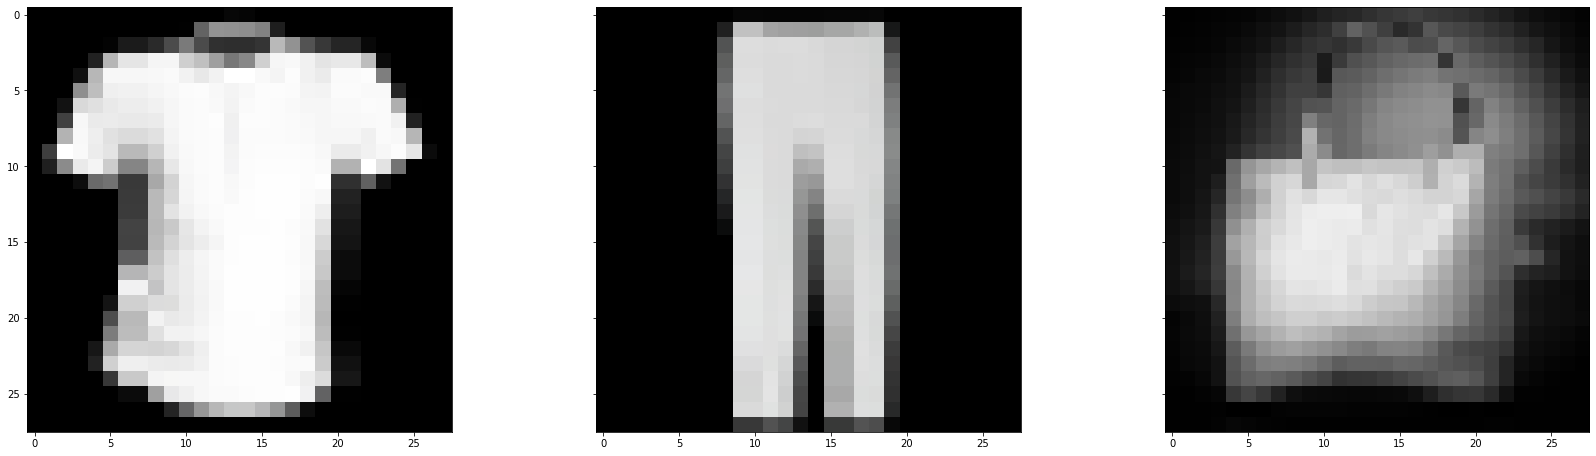

In [80]:
import imageio
import glob
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


fig = plt.figure(figsize=(28., 28.))
grid = ImageGrid(fig, 111,  
                 nrows_ncols=(1, 3),  
                 axes_pad=2)

ims = []
real_imgs = []
for image_path in glob.glob("test_image/*.png"):
    img= Image.open(image_path)
    img_L = img.convert('L')
    ims.append(img)
    img_nd = np.array(img_L.getdata())
    imgg = np.ndarray((28,28), buffer=img_nd)
    imgg = np.float32(imgg)
    real_imgs.append([imgg])
    print(imgg.shape)
    print(imgg.dtype)
real_imgs.append([imgg])

for ax, im in zip(grid, ims):
    ax.imshow(im,cmap='gray', interpolation='none')
    
plt.plot()


### 3.2 Test your network on the real images and display the classification results. (5 marks)

In [88]:
PATH = './cifar_net.pth'
real_word_test = CNN()
real_word_test.load_state_dict(torch.load(PATH))
trX = torch.tensor(real_imgs)
# trX = torch.from_numpy(np.stack(real_imgs))
print(trX.shape)
outputs = real_word_test(trX)
predicted = torch.max(outputs.data, 1)[1]
print(predicted)

torch.Size([4, 1, 28, 28])
tensor([2, 2, 2, 2])


### 3.3 Discuss the classification results. (5 marks)

Does the model work? Is there anyway to improve the real life performance of the model?